In [1]:
import json

import matplotlib.pyplot as plt

import cv2
import numpy as np

from PIL import Image
from sklearn.cluster import KMeans
from collections import Counter

from music21 import stream, chord, note, midi
import pygame
from IPython.display import Audio

pygame 2.6.0 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Motif of sleeves on a women's shirt from Kyustendil region

I decided to start the conversion of colours into music with a simple repetitive design.

![Design 1](../Images/Design_4.jpg)
)


### Load the Colour to Notes mapping


In [2]:
# Load data from JSON file
with open('../color_data.json', 'r') as json_file:
    color_data = json.load(json_file)

# Convert RGB values from lists to tuples for immutability
target_colors = [tuple(data["RGB"]) for data in color_data.values()]

# Create color_to_note mapping with tuples as keys
color_to_note = {tuple(data["RGB"]): data["Note"] for data in color_data.values()}


### Image Crop 

As the desing is repetitive, I will leave first 615 pixels from the left.

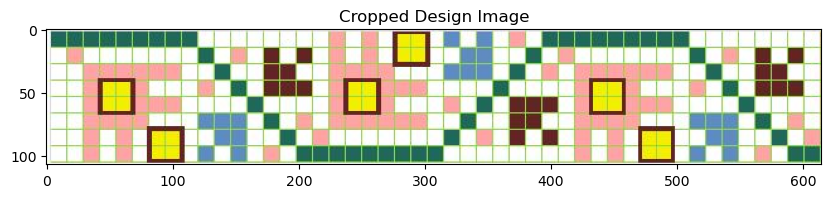

Cropped image saved to ../Images/Cropped_Design_image.png


In [3]:
# Load the design image
design_image_path = '../Images/Design_4.JPG'
design_image = cv2.imread(design_image_path)

# Crop the image to leave 615 pixels in width
cropped_width = 615
cropped_image = design_image[:, :cropped_width]

"""
Convert the cropped image to RGB (OpenCV loads images in BGR format). 
The conversion from BGR to RGB is necessary to ensure that the color representation is accurate when 
interfacing with libraries or systems that expect images in RGB format. 
This conversion aligns with the expectations of these libraries and ensures that the colors are displayed or processed correctly.
""" 
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Display the cropped image
plt.figure(figsize=(10, 5))
plt.title('Cropped Design Image')
plt.imshow(cropped_image_rgb)
plt.show()

# Save the cropped image
output_path = '../Images/Cropped_Design_image.png'
cv2.imwrite(output_path, cv2.cvtColor(cropped_image_rgb, cv2.COLOR_RGB2BGR))
print(f"Cropped image saved to {output_path}")


### Remove the green color

The Green colour is presented in all the columns. I want to avoid this repetition.

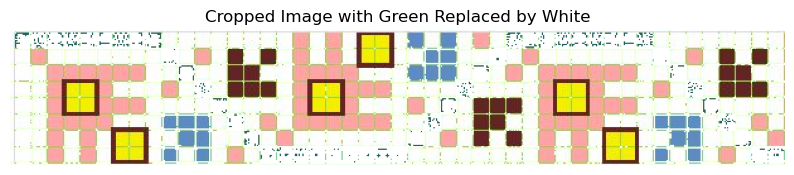

In [4]:
# Define the green color range in RGB
lower_green = np.array([0, 100, 0])
upper_green = np.array([173, 255, 150])

# Create a mask to identify the green areas in the image
mask = cv2.inRange(cropped_image_rgb, lower_green, upper_green)

# Convert the green areas to white
cropped_image_rgb[mask > 0] = [255, 255, 255]

# Convert the numpy array to PIL image
image_pil = Image.fromarray(cropped_image_rgb)

# Display the modified image
plt.figure(figsize=(10, 5))
plt.title('Cropped Image with Green Replaced by White')
plt.imshow(image_pil)
plt.axis('off')
plt.show()

# Save the modified image
output_path_replaced_green = '../Images/Cropped_Image_replaced_green.png'
image_pil.save(output_path_replaced_green)

### Map the colours to the colour palette

Next steps are to dimish the number of the colors and the image size. Then the colours in the current design will be mapped to the colour palette. 

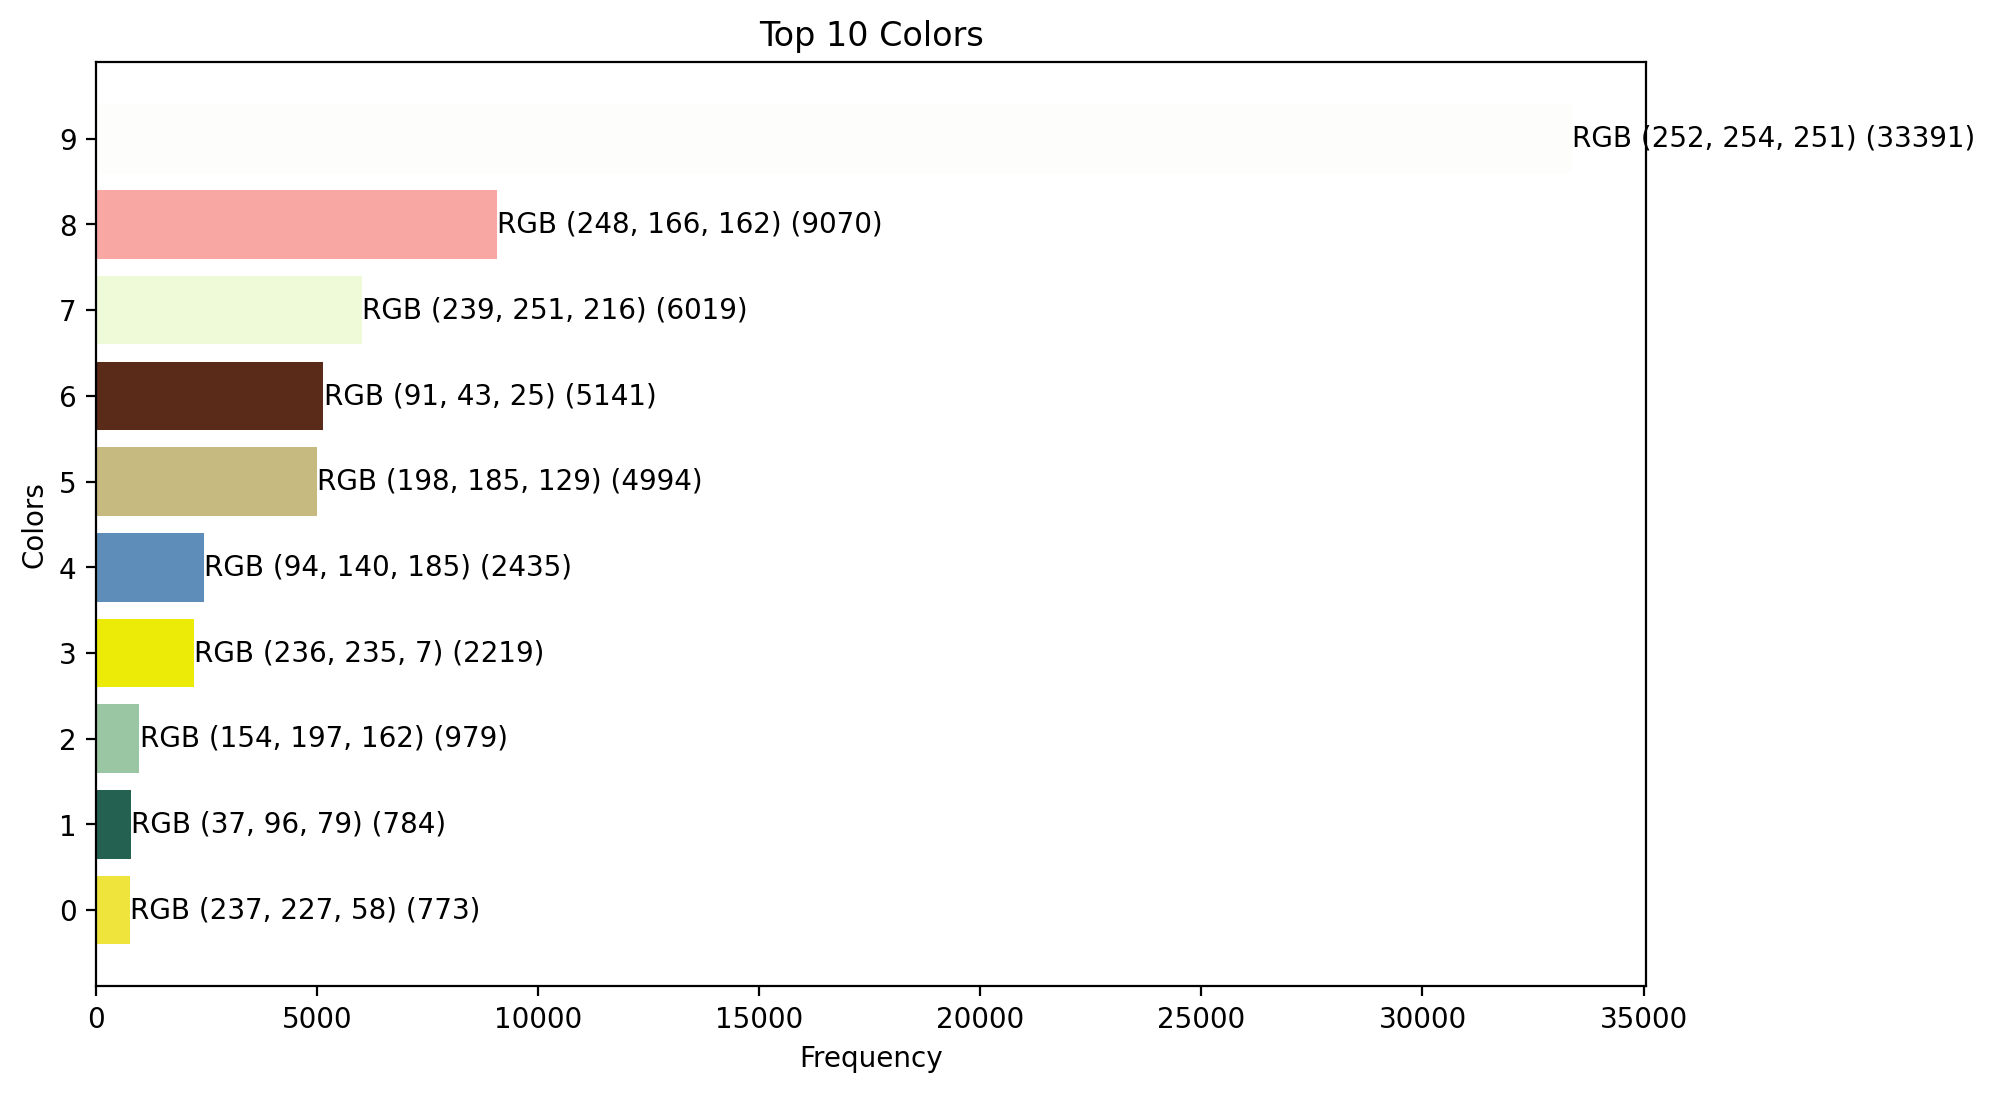

In [5]:
# Load the image
image_path = '../Images/Cropped_Image_replaced_green.PNG'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use KMeans to find the top 10 colors
num_colors = 10
kmeans = KMeans(n_clusters=num_colors, n_init=10)  # Set n_init explicitly
kmeans.fit(pixels)

# Get the colors and their frequencies
colors = kmeans.cluster_centers_
labels = kmeans.labels_
label_counts = Counter(labels)

# Sort the colors by frequency
sorted_colors = [colors[i] for i in label_counts.keys()]
sorted_counts = [label_counts[i] for i in label_counts.keys()]
sorted_indices = np.argsort(sorted_counts)[::-1]

top_colors = np.array(sorted_colors)[sorted_indices]
top_counts = np.array(sorted_counts)[sorted_indices]

# Display the top ten colors
def plot_colors(colors, counts):
    # Sort colors and counts by frequency in ascending order
    sorted_indices = np.argsort(counts)[::1]
    sorted_colors = np.array(colors)[sorted_indices]
    sorted_counts = np.array(counts)[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Colors')
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(sorted_colors)), sorted_counts, color=sorted_colors / 255)
    
    # Add color labels next to each bar
    for bar, color, count in zip(bars, sorted_colors, sorted_counts):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'RGB {tuple(map(int, color))} ({count})', 
                 va='center', ha='left', fontsize=10)

    plt.xlabel('Frequency')
    plt.ylabel('Colors')
    plt.yticks(range(len(sorted_colors)))
    plt.show()

# Plot the top ten colors
plot_colors(top_colors[:num_colors], top_counts[:num_colors])


In [6]:
image_path = "../Images/Cropped_Image_replaced_green.png"
img = Image.open(image_path)

# Resize the image to 47x8
img_resized = img.resize((47, 8), Image.NEAREST)

# Function to find the nearest color from the target palette
def closest_color(pixel, colors):
    colors = np.array(colors)
    distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
    return colors[np.argmin(distances)]

# Get the image data as a numpy array
pixels = np.array(img_resized)

# Create an array to hold the new pixel data
new_pixels = np.zeros_like(pixels)

# Map each pixel to the nearest color in the palette
for i in range(pixels.shape[0]):
    for j in range(pixels.shape[1]):
        new_pixels[i, j] = closest_color(pixels[i, j], target_colors)

# Convert the new pixel array back to an image
new_img = Image.fromarray(new_pixels.astype('uint8'), 'RGB')

# Save the new image
new_image_path = "../Images/Pixelated_Image_Converted.png"
new_img.save(new_image_path)


In [7]:
# Load the design image
design_image_path = 'Pixelated_Image_Converted.png'
design_image = cv2.imread(design_image_path)


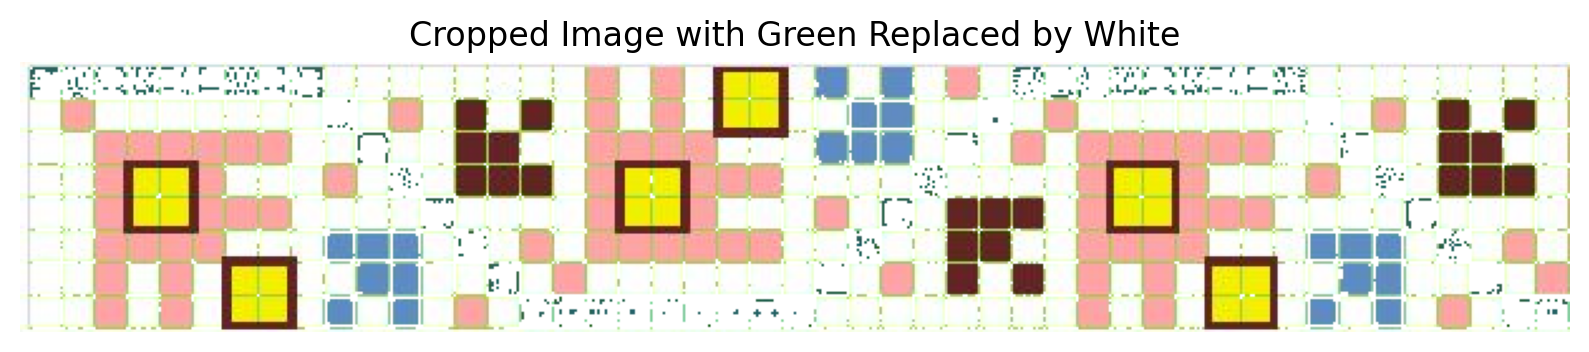

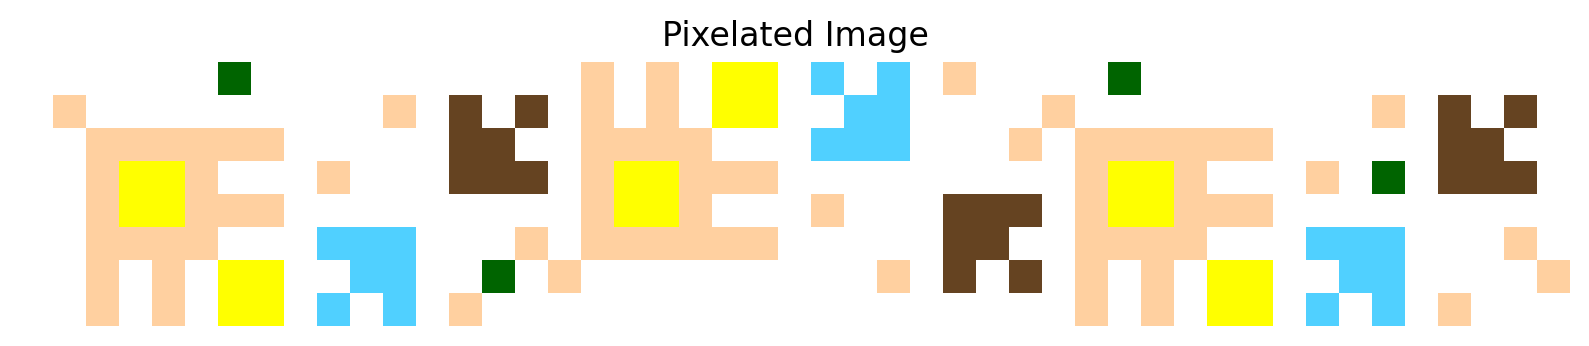

In [8]:
# Display the modified image
plt.figure(figsize=(10, 5))
plt.title('Cropped Image with Green Replaced by White')
plt.imshow(image_pil)
plt.axis('off')
plt.show()

# Load the image
image_path = '../Images/Pixelated_Image_Converted.png' 
design_image = cv2.imread(image_path)

# Check if the image was loaded correctly
if design_image is None:
    raise ValueError(f"Error: Image at path '{image_path}' failed to load. Please check the file path or format.")
else:
    # Convert BGR image to RGB
    design_image_rgb = cv2.cvtColor(design_image, cv2.COLOR_BGR2RGB)

    # Display the pixelated image in RGB format
    plt.figure(figsize=(10, 5))
    plt.title('Pixelated Image')
    plt.imshow(design_image_rgb)
    plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()



### Convert the colours into chords

It is time to convert the pixelated image into music chords. Each column will represent one chord (combination between one or more notes, or silence). The notes are related to the colours. To simplify the model, I will remove the duplicated colours in the columns.

In [9]:
design_image_array = np.array(design_image)

In [10]:
# Function to convert BGR to RGB
def bgr_to_rgb(bgr_color):
    return bgr_color[:, :, ::-1]

# Function to get unique colors for each column in RGB order
def unique_colors_by_column(array):
    height, width, _ = array.shape
    unique_colors = []
    
    # Convert the entire image array from BGR to RGB
    rgb_array = bgr_to_rgb(array)
    
    # Iterate over each column
    for col in range(width):
        # Extract the column data across all rows
        column_data = rgb_array[:, col, :]
        
        # Find unique colors in this column
        unique_colors_col = np.unique(column_data, axis=0)
        
        unique_colors.append(unique_colors_col)
    
    return unique_colors

# Get unique colors for each column
unique_colors = unique_colors_by_column(design_image_array)

# Create a list of unique colors for each column
unique_colors_list = [list(map(tuple, colors)) for colors in unique_colors]

# Output the list of unique colors
print(unique_colors_list)


[[(255, 255, 255)], [(255, 208, 160), (255, 255, 255)], [(255, 208, 160), (255, 255, 255)], [(255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 208, 160), (255, 255, 255)], [(0, 100, 0), (255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 255, 255)], [(80, 208, 255), (255, 208, 160), (255, 255, 255)], [(80, 208, 255), (255, 255, 255)], [(80, 208, 255), (255, 208, 160), (255, 255, 255)], [(255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(0, 100, 0), (101, 67, 33), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(255, 208, 160), (255, 255, 255)], [(255, 208, 160), (255, 255, 255)], [(255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 208, 160), (255, 255, 255)], [(255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 208, 160), (255, 255, 0), (255, 255, 255)], [(255, 255, 255)]

In [11]:
# Flatten the list of lists
flat_list = [color for sublist in unique_colors_list for color in sublist]

# Get unique colors
unique_colors = set(flat_list)


In [12]:
# Map each color to its musical note
mapped_notes_list = []
for column in unique_colors_list:
    notes = [color_to_note.get(color, "Unknown") for color in column]
    mapped_notes_list.append(notes)

# Output the list of mapped notes
print(mapped_notes_list)


[['Rest'], ['D4', 'Rest'], ['D4', 'Rest'], ['D4', 'A3', 'Rest'], ['D4', 'A3', 'Rest'], ['D4', 'Rest'], ['F3', 'D4', 'A3', 'Rest'], ['D4', 'A3', 'Rest'], ['Rest'], ['D3', 'D4', 'Rest'], ['D3', 'Rest'], ['D3', 'D4', 'Rest'], ['Rest'], ['C4', 'D4', 'Rest'], ['F3', 'C4', 'Rest'], ['C4', 'D4', 'Rest'], ['D4', 'Rest'], ['D4', 'Rest'], ['D4', 'A3', 'Rest'], ['D4', 'A3', 'Rest'], ['D4', 'Rest'], ['D4', 'A3', 'Rest'], ['D4', 'A3', 'Rest'], ['Rest'], ['D3', 'D4', 'Rest'], ['D3', 'Rest'], ['D3', 'D4', 'Rest'], ['Rest'], ['C4', 'D4', 'Rest'], ['C4', 'Rest'], ['C4', 'D4', 'Rest'], ['D4', 'Rest'], ['D4', 'Rest'], ['F3', 'D4', 'A3', 'Rest'], ['D4', 'A3', 'Rest'], ['D4', 'Rest'], ['D4', 'A3', 'Rest'], ['D4', 'A3', 'Rest'], ['Rest'], ['D3', 'D4', 'Rest'], ['D3', 'Rest'], ['F3', 'D3', 'D4', 'Rest'], ['Rest'], ['C4', 'D4', 'Rest'], ['C4', 'Rest'], ['C4', 'D4', 'Rest'], ['D4', 'Rest']]


### Conver the chords into midi file

In [13]:
# Create a stream for the MIDI data
midi_stream = stream.Stream()

# Convert each chord to music21 objects and add to the stream
for chord_notes in mapped_notes_list:
    chord_notes = [note for note in chord_notes if note != 'Rest']
    if chord_notes:
        midi_stream.append(chord.Chord(chord_notes))
    else:
        midi_stream.append(note.Rest())

# Set the duration of each note/chord (assuming quarter notes for simplicity)
for element in midi_stream:
    element.quarterLength = 1.0

# Create a MIDI file
mf = midi.translate.music21ObjectToMidiFile(midi_stream)

# Write the MIDI file to disk
mf.open('../Outputs/output1.mid', 'wb')
mf.write()
mf.close()


### Play the final result

In [14]:
# Initialize pygame
pygame.mixer.init()
pygame.mixer.music.load("../Outputs/output1.mid")
pygame.mixer.music.play()


### Bonus
After additional processing with https://www.soundtrap.com/

In [15]:
audio = Audio('../BonusTrack/Design One v2.mp3')
audio
